This Python notebook serves as a technical companion to our in-depth blog post discussing the challenges associated with managing personally identifiable information (PII) in educational datasets.

It focuses on the BERT (Bidirectional Encoder Representations from Transformers) machine learning model, which **provided the most satisfactory results** in our evaluation. Here, we detail the implementation process, evaluate the performance, and offer comprehensive insights into how the BERT model effectively detects and anonymizes PII, ensuring the privacy and security of student data.

The notebook includes practical code snippets, performance analysis, and explanations to aid in understanding the application of BERT in this critical context.

###**Required Imports**

In [ ]:
# Required Imports
import pandas as pd
import re
import ast
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from transformers import BertTokenizerFast, BertForTokenClassification, AdamW, get_linear_schedule_with_warmup
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
import numpy as np
import torch.nn as nn
from sklearn.metrics import classification_report
from google.colab import drive
from torch import nn
import random

###**Data Loading**

Data can be downloaded from: [Kaggle Pii Data Detection Dataset](https://www.kaggle.com/competitions/pii-detection-removal-from-educational-data/data )

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/ML-Project/PII-DATA'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

# Load the CSV data into a DataFrame
df = pd.read_csv('/content/drive/My Drive/ML-Project/PII-DATA/token-labels.csv')

# Display the first few rows of the DataFrame to verify it's loaded correctly
df


,document,words,labels
0,7,"['Design', 'Thinking', 'for', 'innovation', 'r...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
1,10,"['Diego', 'Estrada', '\n\n', 'Design', 'Thinki...","['B-NAME_STUDENT', 'I-NAME_STUDENT', 'O', 'O',..."
2,16,"['Reporting', 'process', '\n\n', 'by', 'Gilber...","['O', 'O', 'O', 'O', 'B-NAME_STUDENT', 'I-NAME..."
3,20,"['Design', 'Thinking', 'for', 'Innovation', '\...","['O', 'O', 'O', 'O', 'O', 'B-NAME_STUDENT', 'I..."
4,56,"['Assignment', ':', '\xa0 ', 'Visualization', ...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
...,...,...,...
11236,29429,"['Hello,', ""I'm"", 'Nicholas', 'Moore,', 'a', '...","['O', 'O', 'B-NAME_STUDENT', 'I-NAME_STUDENT',..."
11237,29430,"['Hello,', 'my', 'name', 'is', 'Alexey', 'Novi...","['O', 'O', 'O', 'O', 'B-NAME_STUDENT', 'I-NAME..."
11238,29431,"['My', 'name', 'is', 'Ludmila', 'Inoue,', 'and...","['O', 'O', 'O', 'B-NAME_STUDENT', 'I-NAME_STUD..."
11239,29432,"['Dr.', 'Tu', 'Garcia,', 'a', 'renowned', 'der...","['O', 'B-NAME_STUDENT', 'I-NAME_STUDENT', 'O',..."


In [ ]:
# Define a list of unique labels used in the dataset
unique_labels = [
    'O', 'B-NAME_STUDENT', 'I-NAME_STUDENT', 'B-URL_PERSONAL', 'B-EMAIL',
    'B-ID_NUM', 'I-URL_PERSONAL', 'B-USERNAME', 'B-PHONE_NUM', 'I-PHONE_NUM',
    'B-STREET_ADDRESS', 'I-STREET_ADDRESS', 'I-ID_NUM'
]

# Create a dictionary to map label indices to their respective labels
id2label = {
    0: 'O', 1: 'B-NAME_STUDENT', 2: 'I-NAME_STUDENT', 3: 'B-URL_PERSONAL',
    4: 'B-EMAIL', 5: 'B-ID_NUM', 6: 'I-URL_PERSONAL', 7: 'B-USERNAME',
    8: 'B-PHONE_NUM', 9: 'I-PHONE_NUM', 10: 'B-STREET_ADDRESS',
    11: 'I-STREET_ADDRESS', 12: 'I-ID_NUM'
}


In [ ]:
# import ast
# df['words'] = df['words'].apply(ast.literal_eval)
# df['labels'] = df['labels'].apply(ast.literal_eval)


###**Data Cleaning Functions**

In [ ]:
import re
import ast

def clean_words_and_labels(words, labels):
    """
    Cleans words by removing whitespace and corresponding labels if the word is empty after cleaning.
    :param words: List of words to be cleaned.
    :param labels: Corresponding labels for the words.
    :return: Tuple of lists containing cleaned words and their corresponding labels.
    """
    # Clean words and remove corresponding labels if the word is just whitespace or empty after cleaning.
    cleaned_words = []
    cleaned_labels = []
    for word, label in zip(words, labels):
        # Apply any specific cleaning necessary for each word
        cleaned_word = re.sub(r'\s+', '', word).strip()
        # Only add words and labels that are not empty after cleaning
        if cleaned_word:
            cleaned_words.append(cleaned_word)
            cleaned_labels.append(label)
    return cleaned_words, cleaned_labels

# Assuming 'words' and 'labels' columns contain string representations of lists
# Convert string representation of a list to actual list
df['words'] = df['words'].apply(ast.literal_eval)
df['labels'] = df['labels'].apply(ast.literal_eval)

# Apply the cleaning function to each pair of words and labels
cleaned_data = df.apply(lambda row: clean_words_and_labels(row['words'], row['labels']), axis=1)

# Separate the cleaned words and labels into their own columns
df['cleaned_words'] = cleaned_data.apply(lambda x: x[0])
df['cleaned_labels'] = cleaned_data.apply(lambda x: x[1])


In [ ]:
df.drop(columns=['words', 'labels'], inplace=True)

In [ ]:
df

,document,cleaned_words,cleaned_labels
0,7,"[Design, Thinking, for, innovation, reflexion,...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-..."
1,10,"[Diego, Estrada, Design, Thinking, Assignment,...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O..."
2,16,"[Reporting, process, by, Gilberto, Gamboa, Cha...","[O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O, O..."
3,20,"[Design, Thinking, for, Innovation, Sindy, Sam...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O..."
4,56,"[Assignment, :, Visualization, Reflection, Sub...","[O, O, O, O, O, O, O, B-NAME_STUDENT, I-NAME_S..."
...,...,...,...
11236,29429,"[Hello,, I'm, Nicholas, Moore,, a, man, with, ...","[O, O, B-NAME_STUDENT, I-NAME_STUDENT, O, O, O..."
11237,29430,"[Hello,, my, name, is, Alexey, Novikov, and, I...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O..."
11238,29431,"[My, name, is, Ludmila, Inoue,, and, I'm, a, p...","[O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O, O..."
11239,29432,"[Dr., Tu, Garcia,, a, renowned, dermatologist,...","[O, B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O..."


In [ ]:
def remove_quotes_from_cleaned_words(df):
    """
    Removes quotes from each word in the 'cleaned_words' column of the DataFrame.
    :param df: DataFrame containing the 'cleaned_words' column.
    :return: DataFrame with quotes removed from words.
    """
    # Removing quotes from each word in the 'cleaned_words' column
    df['cleaned_words'] = df['cleaned_words'].apply(lambda words: [word.replace('"', '') for word in words])
    return df

df = remove_quotes_from_cleaned_words(df)

####Sanity Checks

In [ ]:
def verify_and_display_alignment(df):
    # Check if each list of 'cleaned_words' has a corresponding list of 'cleaned_labels'
    for index, row in df.iterrows():
        words = row['cleaned_words']
        labels = row['cleaned_labels']
        if len(words) != len(labels):
            print(f"Mismatch found in document {index}: {len(words)} words, {len(labels)} labels")
            break
    else: # This else belongs to the for loop and executes if the loop doesn't break
        print("Each word has a corresponding label.")

    # Display words and labels for the first two 'sentences'
    for index, (words, labels) in enumerate(zip(df['cleaned_words'][2:5], df['cleaned_labels'][2:5])):
        print(f"\nSentence {index + 1}:")
        for word, label in zip(words, labels):
            print(f"{word}: {label}")

# Assuming 'df' is your dataframe and it contains 'cleaned_words' and 'cleaned_labels' columns
verify_and_display_alignment(df)


###**Exploratory Data Analysis**

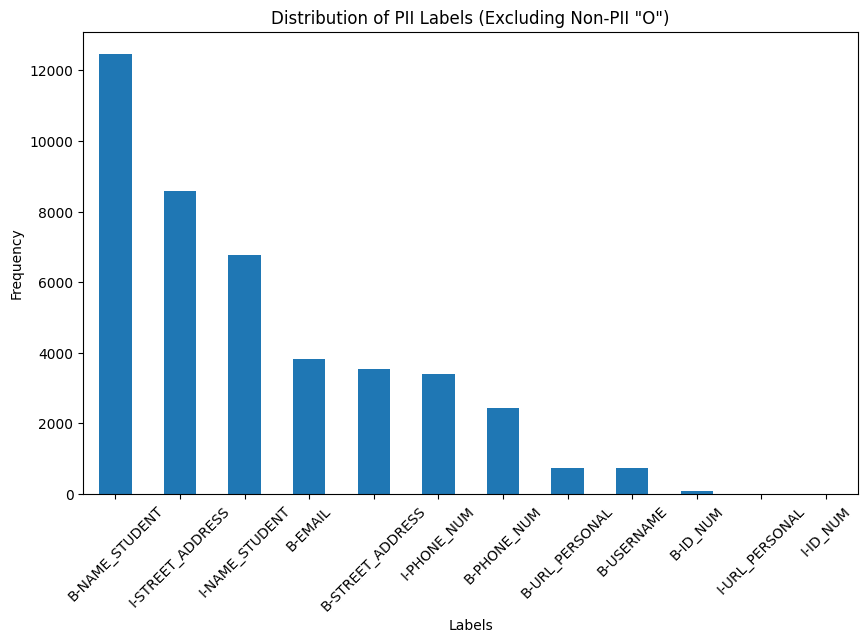

In [ ]:
# Explode the 'cleaned_labels' column and filter out 'O' which represent non-PII (Personally Identifiable Information) data before counting
label_counts = df['cleaned_labels'].explode().value_counts().drop('O', errors='ignore')

# Plotting the label distribution without 'O'
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.title('Distribution of PII Labels (Excluding Non-PII "O")')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


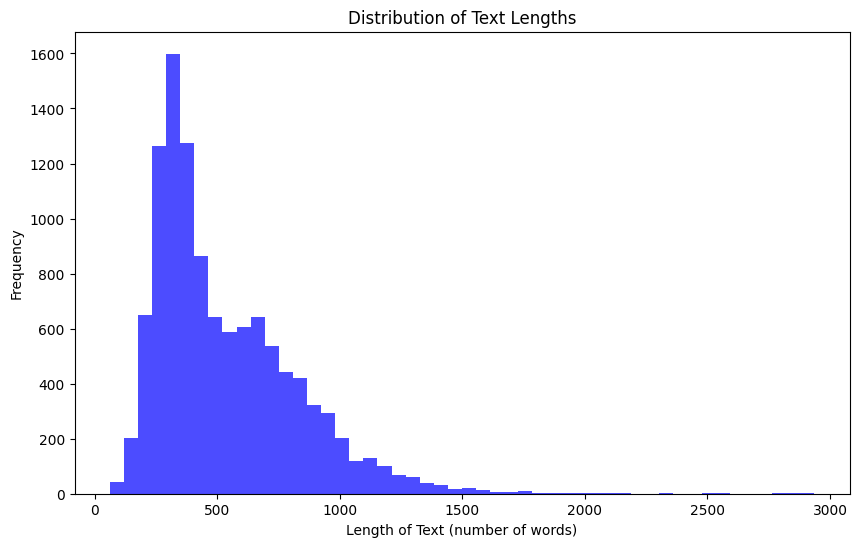

In [ ]:
# Adding a new column to the DataFrame that represents the text length in terms of the number of words
df['text_length'] = df['cleaned_words'].apply(len)

# Plotting the text length distribution
plt.figure(figsize=(10, 6))
plt.hist(df['text_length'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Text Lengths')
plt.xlabel('Length of Text (number of words)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
non_o_word_label_pairs = []

In [ ]:
def print_non_O_words_and_labels(df):
    # Get the last five entries in the DataFrame
    last_five = df.iloc[100:105]

    # Iterate over each of the last five entries
    for index, (words, labels) in enumerate(zip(last_five['cleaned_words'], last_five['cleaned_labels'])):
        print(f"Document {index + len(df) - 5}:")
        # Create a list of tuples (word, label) where the label is not 'O'
        non_O_word_label_pairs = [(word, label) for word, label in zip(words, labels) if label != 'O']

        # Print each word with its non-'O' label
        for word, label in non_O_word_label_pairs:
            print(f"{word}: {label}")

# Call the function to print the words and their labels
# This should be run in your local environment
print_non_O_words_and_labels(df)


Document 11236:
Amal: B-NAME_STUDENT
Bhai: I-NAME_STUDENT
Document 11237:
Ahmed: B-NAME_STUDENT
Figo: I-NAME_STUDENT
Document 11238:
Guddu: B-NAME_STUDENT
Singh: I-NAME_STUDENT
Document 11239:
Ahmed: B-NAME_STUDENT
Salem: I-NAME_STUDENT
tps://www.facebook.com/bclark: B-URL_PERSONAL
https://www.youtube.com/channel/UC1ElAcppeuhfet: B-URL_PERSONAL
nYZqnhEXw: I-URL_PERSONAL
Ahmed: B-NAME_STUDENT
Salem: I-NAME_STUDENT
Document 11240:
Fabio: B-NAME_STUDENT
Sameh: I-NAME_STUDENT


###**Label Mapping and Conversion to Integer IDs**

In [ ]:
# Invert the id2label mapping to create a label2id mapping
label2id = {label: id for id, label in id2label.items()}


# Corrected conversion function that can handle a list of lists
def convert_labels_to_integers(label_series, mapping):

    integer_labels = []
    for labels in label_series:
        int_label_row = []
        for label in labels:
            # Check if the label is in the mapping, otherwise ignore it
            if label in mapping:
                int_label_row.append(mapping[label])
        integer_labels.append(int_label_row)
    return integer_labels

# Apply the function to the 'cleaned_labels' column with the new mapping
df['integer_labels'] = convert_labels_to_integers(df['cleaned_labels'], label2id)

df[['cleaned_words', 'integer_labels']]


,cleaned_words,integer_labels
0,"[Design, Thinking, for, innovation, reflexion,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, ..."
1,"[Diego, Estrada, Design, Thinking, Assignment,...","[1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[Reporting, process, by, Gilberto, Gamboa, Cha...","[0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[Design, Thinking, for, Innovation, Sindy, Sam...","[0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[Assignment, :, Visualization, Reflection, Sub...","[0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, ..."
...,...,...
11236,"[Hello,, I'm, Nicholas, Moore,, a, man, with, ...","[0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
11237,"[Hello,, my, name, is, Alexey, Novikov, and, I...","[0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
11238,"[My, name, is, Ludmila, Inoue,, and, I'm, a, p...","[0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
11239,"[Dr., Tu, Garcia,, a, renowned, dermatologist,...","[0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
final = df[['cleaned_words', 'integer_labels']]

In [ ]:
final.rename(columns={'integer_labels': 'cleaned_labels'}, inplace=True)

<ipython-input-42-c55765b59f3b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final.rename(columns={'integer_labels': 'cleaned_labels'}, inplace=True)


In [ ]:
final

,cleaned_words,cleaned_labels
0,"[Design, Thinking, for, innovation, reflexion,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, ..."
1,"[Diego, Estrada, Design, Thinking, Assignment,...","[1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[Reporting, process, by, Gilberto, Gamboa, Cha...","[0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[Design, Thinking, for, Innovation, Sindy, Sam...","[0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[Assignment, :, Visualization, Reflection, Sub...","[0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, ..."
...,...,...
11236,"[Hello,, I'm, Nicholas, Moore,, a, man, with, ...","[0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
11237,"[Hello,, my, name, is, Alexey, Novikov, and, I...","[0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
11238,"[My, name, is, Ludmila, Inoue,, and, I'm, a, p...","[0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
11239,"[Dr., Tu, Garcia,, a, renowned, dermatologist,...","[0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


###**Split data into training, testing and validation sets**

In [ ]:
from sklearn.model_selection import train_test_split

# Then you can use the train_test_split function
train_val_df, test_df = train_test_split(final, test_size=0.1, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=(1/9), random_state=42)


In [ ]:
train_df

,cleaned_words,cleaned_labels
7245,"[During, my, tenure, as, a, designer, at, Matr...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9681,"[In, the, realm, of, healthcare,, I,, Delun, V...","[0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, ..."
1097,"[STORYTELLING, IS, A, MUST, -, HAVE, TOOL, Cha...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5778,"[Reflection, :, Mind, Mapping, Tool, Describe,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3631,"[Reflection, -, Storytelling, Challenge, I, to...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...
10145,"[In, the, realm, of, the, deceased,, where, th...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7254,"[As, a, jeweler,, I've, had, the, privilege, o...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
884,"[VISUALIZATION, Challange, and, selection, The...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5956,"[Reflection, -, Learning, Launching, Challenge...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
val_df

,cleaned_words,cleaned_labels
7714,"[In, the, annals, of, exemplary, nursing, prof...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, ..."
9463,"[My, name, is, Kyle, Yamamoto,, and, I, work, ...","[0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6895,"[In, my, role, as, a, pharmacist, with, two, y...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
133,"[Mind, Mapping, Challenge, :, My, challenge, i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
404,"[Design, Thinking, for, Innovation, by, Univer...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, ..."
...,...,...
4220,"[Visualization, as, a, tool, Challenge, :, Fas...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9578,"[Greetings!, Allow, me, to, introduce, myself,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, ..."
5605,"[Learning, Launch, –, Communication, processes...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4424,"[Challenge, &, Selection, For, my, study, as, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
test_df

,cleaned_words,cleaned_labels
4170,"[Reflection, –, Mind, Mapping, Challenge, An, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6967,"[Hi,, my, name, is, Carmen, Chen, and, I, work...","[0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
318,"[Federation, By, Sara, Garcia, Challenge, With...","[0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3473,"[Example, Reflection, -, Learning, Launch, Cha...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7680,"[Isaac, Scott,, a, dedicated, school, teacher,...","[1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...
7234,"[In, a, bustling, city, where, skyscrapers, pi...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5417,"[Mind, Mapping, Challenge, &, Selection, As, a...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4110,"[Reflection, Paper, on, Storytelling, Challeng...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7579,"[Hello,, my, name, is, Anil, Morozov., I, was,...","[0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


###**Insert [CLS] and [SEP] Tokens for Transformer Models**

In [ ]:
def insert_cls_sep(df):
    updated_data = []
    for _, row in df.iterrows():
        words = row['cleaned_words']
        labels = row['cleaned_labels']
        new_words = ['[CLS]']
        new_labels = [-101]

        for i, word in enumerate(words):
            # Append the word and its label
            new_words.append(word.strip('"'))  # Remove quotes and add word
            new_labels.append(labels[i])

            # Check if the word ends with a period or is a period
            if word.endswith('.'):
                # Append [SEP] after a word that ends with a period
                new_words.append('[SEP]')
                new_labels.append(-101)

                # If this word is not the last word, start a new sentence with [CLS]
                if i < len(words) - 1:
                    new_words.append('[CLS]')
                    new_labels.append(-101)

        # Ensure there is a [SEP] at the end of the last sentence if not already there
        if new_words[-1] != '[SEP]':
            new_words.append('[SEP]')
            new_labels.append(-101)

        updated_data.append({'cleaned_words': new_words, 'cleaned_labels': new_labels})

    return pd.DataFrame(updated_data)

# Assume train_df, val_df, and test_df are your DataFrames
# You would call the function like this:
updated_train_df = insert_cls_sep(train_df)
updated_val_df = insert_cls_sep(val_df)
updated_test_df = insert_cls_sep(test_df)


###**Check [CLS] and [SEP] Token Placement**

In [ ]:
def check_cls_sep_tokens(df):
    """
    Prints the placement of [CLS] and [SEP] tokens for the first row of the DataFrame to verify correct insertion.

    :param df: DataFrame with tokenized data including special tokens.
    """
    first_row_words = df.iloc[0]['cleaned_words']
    first_row_labels = df.iloc[0]['cleaned_labels']
    assert len(first_row_words) == len(first_row_labels), "Mismatch in lengths of tokens and labels"

    for token, label in zip(first_row_words, first_row_labels):
        print(f"{token} ({label})", end=' ')

    print("\n\nCheck if [CLS] and [SEP] with -101 labels are correctly placed:")
    print("Start of sentence:", first_row_words[0], first_row_labels[0])
    print("End of sentence:", first_row_words[-1], first_row_labels[-1])

    # Check if [CLS] and [SEP] are correctly added after each period
    for i in range(1, len(first_row_words)-1):
        if first_row_words[i] == '.':
            print("Period detected at position", i)
            print("Should be [SEP] next:", first_row_words[i+1], first_row_labels[i+1])
            print("Should be [CLS] after [SEP] if not last:", first_row_words[i+2] if i+2 < len(first_row_words) else "N/A",
                  first_row_labels[i+2] if i+2 < len(first_row_labels) else "N/A")

# Use the function on your DataFrame
check_cls_sep_tokens(updated_train_df)


[CLS] (-101) During (0) my (0) tenure (0) as (0) a (0) designer (0) at (0) Matrix (0) Studios, (0) I (0) embarked (0) on (0) a (0) project (0) that (0) challenged (0) my (0) creativity (0) and (0) pushed (0) the (0) boundaries (1) of (0) design. (0) [SEP] (-101) [CLS] (-101) The (0) task (0) was (0) to (0) create (0) a (0) captivating (0) and (0) immersive (0) visual (0) experience (0) for (0) the (0) company's (0) latest (0) video (0) game, (0) Cosmic (0) Odyssey. (0) [SEP] (-101) [CLS] (-101) My (0) journey (0) began (0) with (0) extensive (0) research, (0) delving (0) into (0) the (0) realm (0) of (0) science (0) fiction (0) and (0) exploring (0) the (0) vastness (0) of (0) space. (0) [SEP] (-101) [CLS] (-101) I (0) spent (0) countless (0) hours (0) studying (0) celestial (0) bodies, (0) nebulae, (0) and (0) distant (0) galaxies, (0) drawing (0) inspiration (0) from (0) their (0) breathtaking (0) beauty. (0) [SEP] (-101) [CLS] (-101) Armed (0) with (0) this (0) knowledge, (0) I (0) 

###**Count Sentences Per Row**

In [ ]:
def count_sentences_per_row(df):
    # Count the number of sentences based on [CLS] tokens
    df['sentence_count'] = df['cleaned_words'].apply(lambda words: words.count('[CLS]'))
    return df

#Call the function on the updated_train_df DataFrame
updated_train_df = count_sentences_per_row(updated_train_df)


#To see the sentence count for each row, you can now print or inspect the 'sentence_count' column:
print(updated_train_df['sentence_count'])


0       20
1       28
2       33
3       55
4       27
        ..
8987    29
8988    15
8989    51
8990    28
8991    15
Name: sentence_count, Length: 8992, dtype: int64


In [ ]:
#Call the function on the updated_train_df DataFrame
updated_test_df = count_sentences_per_row(updated_test_df)


#To see the sentence count for each row, you can now print or inspect the 'sentence_count' column:
print(updated_test_df['sentence_count'])

0       26
1       13
2       23
3       15
4       21
        ..
1120    13
1121    13
1122    24
1123    16
1124    14
Name: sentence_count, Length: 1125, dtype: int64


In [ ]:

#Call the function on the updated_train_df DataFrame
updated_val_df = count_sentences_per_row(updated_val_df)


#To see the sentence count for each row, you can now print or inspect the 'sentence_count' column:
print(updated_val_df['sentence_count'])

0       23
1       17
2       14
3       18
4       24
        ..
1119    29
1120    15
1121    13
1122    20
1123    15
Name: sentence_count, Length: 1124, dtype: int64


In [ ]:
# Selecting only 'cleaned_words' and 'cleaned_labels' columns for train, test, and validation sets
train = updated_train_df[['cleaned_words', 'cleaned_labels']]
test = updated_test_df[['cleaned_words', 'cleaned_labels']]
val = updated_val_df[['cleaned_words', 'cleaned_labels']]


In [ ]:
train

,cleaned_words,cleaned_labels
0,"[[CLS], During, my, tenure, as, a, designer, a...","[-101, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[[CLS], In, the, realm, of, healthcare,, I,, D...","[-101, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, ..."
2,"[[CLS], STORYTELLING, IS, A, MUST, -, HAVE, TO...","[-101, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[[CLS], Reflection, :, Mind, Mapping, Tool, De...","[-101, 0, 0, 0, 0, 0, 0, 0, 0, 0, -101, -101, ..."
4,"[[CLS], Reflection, -, Storytelling, Challenge...","[-101, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...
8987,"[[CLS], In, the, realm, of, the, deceased,, wh...","[-101, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8988,"[[CLS], As, a, jeweler,, I've, had, the, privi...","[-101, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8989,"[[CLS], VISUALIZATION, Challange, and, selecti...","[-101, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8990,"[[CLS], Reflection, -, Learning, Launching, Ch...","[-101, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
test

,cleaned_words,cleaned_labels
0,"[[CLS], Reflection, –, Mind, Mapping, Challeng...","[-101, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[[CLS], Hi,, my, name, is, Carmen, Chen, and, ...","[-101, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[[CLS], Federation, By, Sara, Garcia, Challeng...","[-101, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[[CLS], Example, Reflection, -, Learning, Laun...","[-101, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[[CLS], Isaac, Scott,, a, dedicated, school, t...","[-101, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...
1120,"[[CLS], In, a, bustling, city, where, skyscrap...","[-101, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1121,"[[CLS], Mind, Mapping, Challenge, &, Selection...","[-101, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1122,"[[CLS], Reflection, Paper, on, Storytelling, C...","[-101, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1123,"[[CLS], Hello,, my, name, is, Anil, Morozov., ...","[-101, 0, 0, 0, 0, 1, 2, -101, -101, 0, 0, 0, ..."


In [ ]:
val

,cleaned_words,cleaned_labels
0,"[[CLS], In, the, annals, of, exemplary, nursin...","[-101, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, ..."
1,"[[CLS], My, name, is, Kyle, Yamamoto,, and, I,...","[-101, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, -101, ..."
2,"[[CLS], In, my, role, as, a, pharmacist, with,...","[-101, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[[CLS], Mind, Mapping, Challenge, :, My, chall...","[-101, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[[CLS], Design, Thinking, for, Innovation, by,...","[-101, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, ..."
...,...,...
1119,"[[CLS], Visualization, as, a, tool, Challenge,...","[-101, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1120,"[[CLS], Greetings!, Allow, me, to, introduce, ...","[-101, 0, 0, 0, 0, 0, 0, 0, -101, -101, 0, 0, ..."
1121,"[[CLS], Learning, Launch, –, Communication, pr...","[-101, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1122,"[[CLS], Challenge, &, Selection, For, my, stud...","[-101, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


###**Sliding Window Tokenization Setup**

In [ ]:
from transformers import BertTokenizerFast
import torch

# Initialize the tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

def sliding_window_tokenization_and_labels(words, labels, max_len=512, slide_len=256):
    tokenized_inputs = {
        "input_ids": [],
        "attention_mask": [],
        "labels": []
    }
    # Process each sequence with sliding windows
    start_index = 0
    while start_index < len(words):
        end_index = start_index + slide_len
        window_words = words[start_index:end_index]
        window_labels = labels[start_index:end_index]

        # Tokenization and padding to max length
        inputs = tokenizer(
            window_words,
            is_split_into_words=True,
            add_special_tokens=False,  # We already have [CLS] and [SEP] in our sequence
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Align labels with the tokenized word IDs, adding -101 for ignored tokens
        word_ids = inputs.word_ids(0)  # Batch index 0 since we're processing one sequence at a time
        window_aligned_labels = [-101 if word_id is None else window_labels[word_id] for word_id in word_ids]

        # Append the tokenized results
        tokenized_inputs['input_ids'].append(inputs['input_ids'].squeeze(0))
        tokenized_inputs['attention_mask'].append(inputs['attention_mask'].squeeze(0))
        tokenized_inputs['labels'].append(torch.tensor(window_aligned_labels, dtype=torch.long))

        # Move start index to the next slide
        start_index += slide_len

    # Stack all the tensors
    tokenized_inputs['input_ids'] = torch.stack(tokenized_inputs['input_ids'])
    tokenized_inputs['attention_mask'] = torch.stack(tokenized_inputs['attention_mask'])
    tokenized_inputs['labels'] = torch.stack(tokenized_inputs['labels'])

    return tokenized_inputs


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

###**Data Preparation for Training, Testing, and Validation**

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Initialize lists to hold the tokenized data for all rows
train_input_ids = []
train_attention_masks = []
train_labels = []

# Example usage for each row in your DataFrame


for index, row in train.iterrows():
    tokenized_train_data = sliding_window_tokenization_and_labels(
        row['cleaned_words'], row['cleaned_labels']
    )
    train_input_ids.append(tokenized_train_data['input_ids'])
    train_attention_masks.append(tokenized_train_data['attention_mask'])
    train_labels.append(tokenized_train_data['labels'])


# Now concatenate the lists of tensors into single tensors
train_input_ids = torch.cat(train_input_ids, dim=0)
train_attention_masks = torch.cat(train_attention_masks, dim=0)
train_labels = torch.cat(train_labels, dim=0)

# Convert tokenized data into a TensorDataset
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)

# Define a batch size
batch_size = 16  # You can adjust this according to your requirements

# Create a DataLoader
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)


In [ ]:
# Initialize lists to hold the tokenized data for all rows
test_input_ids = []
test_attention_masks = []
test_labels = []

# Tokenize all the data in the test set
for index,row in test.iterrows():
    tokenized_test_data = sliding_window_tokenization_and_labels(
        row['cleaned_words'], row['cleaned_labels']
    )
    test_input_ids.append(tokenized_test_data['input_ids'])
    test_attention_masks.append(tokenized_test_data['attention_mask'])
    test_labels.append(tokenized_test_data['labels'])


# Concatenate the lists of tensors into single tensors
test_input_ids = torch.cat(test_input_ids, dim=0)
test_attention_masks = torch.cat(test_attention_masks, dim=0)
test_labels = torch.cat(test_labels, dim=0)

# Convert the tokenized test data into a TensorDataset
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)

# For test DataLoader, we usually don't need to shuffle the data, so we use the SequentialSampler
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)


In [ ]:
# Initialize lists to hold the tokenized data for all rows
val_input_ids = []
val_attention_masks = []
val_labels = []

# Tokenize all the data in the validation set
for index, row in val.iterrows():
    tokenized_val_data = sliding_window_tokenization_and_labels(
        row['cleaned_words'], row['cleaned_labels']
    )
    val_input_ids.append(tokenized_val_data['input_ids'])
    val_attention_masks.append(tokenized_val_data['attention_mask'])
    val_labels.append(tokenized_val_data['labels'])

# Concatenate the lists of tensors into single tensors
val_input_ids = torch.cat(val_input_ids, dim=0)
val_attention_masks = torch.cat(val_attention_masks, dim=0)
val_labels = torch.cat(val_labels, dim=0)

# Convert the tokenized validation data into a TensorDataset
val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)

# # For validation DataLoader, we usually don't need to shuffle the data either
# val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=batch_size)
# When initializing your validation dataloader, make sure to set shuffle to False
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=batch_size)


###**Verification of Tokenization and Label Alignment**

In [ ]:
def verify_tokenization_and_labels(tokenizer, input_ids, attention_masks, labels, id2label, num_examples=3):
    """
    Prints tokens and their corresponding labels from the tokenized data to verify correct processing.

    :param tokenizer: Tokenizer used to convert token IDs back to tokens.
    :param input_ids: Tensor of token IDs.
    :param attention_masks: Tensor of attention masks (not used directly in printing).
    :param labels: Tensor of label IDs.
    :param id2label: Dictionary mapping label IDs to label names.
    :param num_examples: Number of examples to display for verification.
    """
    for i in range(num_examples):
        # Get the tokens and label IDs for the current example
        tokens = tokenizer.convert_ids_to_tokens(input_ids[i])
        label_ids = labels[i]

        # Now convert the label IDs to label names using id2label, excluding the ignored indices (-101)
        label_names = [id2label[label_id.item()] if label_id != -101 else 'IGN' for label_id in label_ids]

        # Print the tokens and their labels
        print("{:15} {:5}".format("Token", "Label"))
        for token, label_name in zip(tokens, label_names):
            print("{:15} {:5}".format(token, label_name))
        print("\n")

# Assuming id2label is a dictionary that maps label indices to label names
# Assuming train_input_ids, train_attention_masks, train_labels are the tensors from your tokenized dataset

# Call the function to verify the tokenization and labels
verify_tokenization_and_labels(tokenizer,test_input_ids,test_attention_masks, test_labels, id2label)


Token           Label
[CLS]           IGN  
reflection      O    
–               O    
mind            O    
mapping         O    
challenge       O    
an              O    
insurance       O    
client          O    
of              O    
mine            O    
had             O    
wanted          O    
to              O    
improve         O    
the             O    
efficiency      O    
of              O    
its             O    
planning        O    
and             O    
response        O    
operations      O    
following       O    
catastrophe     O    
events          O    
.               O    
[SEP]           IGN  
[CLS]           IGN  
it              O    
takes           O    
coordination    O    
and             O    
collaboration   O    
amongst         O    
multi           O    
-               O    
functional      O    
teams           O    
such            O    
as              O    
weather         O    
watch           O    
##ers           O    
,         

In [ ]:
print(len(train_input_ids))
print(len(train_attention_masks))
print(len(train_labels))

print(len(test_input_ids))
print(len(test_attention_masks))
print(len(test_labels))

print(len(val_input_ids))
print(len(val_attention_masks))
print(len(val_labels))

24889
24889
24889
3090
3090
3090
3042
3042
3042


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

###**Setup for Weighted Loss Function in PyTorch**

In [ ]:
import torch

# Define the frequency counts of labels
label_freqs = {
    'O': 5929765,  # The 'O' or 'Outside' class
    'B-NAME_STUDENT': 12385,
    'I-STREET_ADDRESS': 8551,
    'I-NAME_STUDENT': 6732,
    'B-EMAIL': 3811,
    'B-STREET_ADDRESS': 3468,
    'I-PHONE_NUM': 3375,
    'B-PHONE_NUM': 2409,
    'B-URL_PERSONAL': 730,
    'B-USERNAME': 724,
    'B-ID_NUM': 78,
    'I-URL_PERSONAL': 1,
    'I-ID_NUM': 1
}


In [ ]:
import  torch
import torch.nn as nn

# Define the frequency counts of labels
# Calculate weights as the inverse of the frequency
weights = 1.0 / torch.tensor(list(label_freqs.values()), dtype=torch.float)

# Normalize the weights so that the most common class ('O') gets a weight of 1
weights = weights / weights[0]  # Assuming 'O' is the first class

# Move the weights to the device
weights = weights.to(device)

# Your loss function now uses these custom weights
loss_fn = nn.CrossEntropyLoss(weight=weights, ignore_index=-101)


In [ ]:
for label, weight in zip(id2label.values(), weights):
    print(f"{label}: {weight:.4f}")

O: 1.0000
B-NAME_STUDENT: 478.7860
I-NAME_STUDENT: 693.4587
B-URL_PERSONAL: 880.8325
B-EMAIL: 1555.9603
B-ID_NUM: 1709.8514
I-URL_PERSONAL: 1756.9673
B-USERNAME: 2461.5046
B-PHONE_NUM: 8122.9658
I-PHONE_NUM: 8190.2832
B-STREET_ADDRESS: 76022.6250
I-STREET_ADDRESS: 5929765.0000
I-ID_NUM: 5929765.0000


###**BERT Model Setup for Token Classification Training**

In [ ]:
from transformers import BertForTokenClassification, AdamW, get_linear_schedule_with_warmup
import torch
from torch.utils.data import DataLoader, RandomSampler, TensorDataset
import torch.nn as nn
# Parameters

num_labels = len(id2label)
batch_size = 16
num_epochs = 50  # Higher number, since early stopping can halt training
learning_rate = 5e-5


model = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)
model.to(device)
model.train()


# Optimizer and Scheduler
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Loss function
loss_fn = nn.CrossEntropyLoss(weight=weights, ignore_index=-101).to(device)

# Early Stopping setup
patience = 3  # Number of epochs to wait after last time validation loss improved.
best_val_loss = float('inf')
best_accuracy = 0
no_improve_epochs = 0

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


###**BERT Model Training and Validation Loop**

In [ ]:
import torch
from transformers import BertForTokenClassification, AdamW, get_linear_schedule_with_warmup
import numpy as np
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
import torch.nn as nn
from sklearn.metrics import classification_report
import random

# Function to calculate accuracy per batch
def batch_accuracy(logits, labels):
    # Get the predictions and compare with true labels
    preds = torch.argmax(logits, dim=-1)
    mask = labels != -101  # Exclude the -101 labels from calculation
    corrects = (preds == labels) & mask  # Correct predictions
    accuracy = corrects.sum().item() / mask.sum().item()
    return accuracy


seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Learning Rate Adjustment Check
def get_current_learning_rate(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']



# Begin training loop
best_val_loss = float('inf')
best_accuracy = 0
no_improve_epochs = 0

initial_model_params = [p.clone() for p in model.parameters()]


# Training loop
for epoch in range(num_epochs):
    print(f"Current Learning Rate: {get_current_learning_rate(optimizer)}")
    total_loss = 0
    total_accuracy = 0

    model.train()

    for batch in train_dataloader:
        input_ids, attention_masks, labels = batch
        input_ids = input_ids.to(device)
        attention_masks = attention_masks.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_masks)

        loss = loss_fn(outputs.logits.view(-1, num_labels), labels.view(-1))
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

        # Calculate batch accuracy from the logits and labels
        batch_acc = batch_accuracy(outputs.logits, labels)
        total_accuracy += batch_acc

    avg_train_loss = total_loss / len(train_dataloader)
    avg_train_accuracy = total_accuracy / len(train_dataloader)
    print(f'Epoch {epoch + 1}, Train Loss: {avg_train_loss}, Train Accuracy: {avg_train_accuracy}')



    model.eval()
    val_loss = 0
    val_accuracy = 0
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids, attention_masks, labels = batch
            input_ids = input_ids.to(device)
            attention_masks = attention_masks.to(device)
            labels = labels.to(device)

            outputs = model(input_ids, attention_mask=attention_masks)

            loss = loss_fn(outputs.logits.view(-1, num_labels), labels.view(-1))
            val_loss += loss.item()

            # Calculate batch accuracy from the logits and labels
            batch_acc = batch_accuracy(outputs.logits, labels)
            val_accuracy += batch_acc

    avg_val_loss = val_loss / len(val_dataloader)
    avg_val_accuracy = val_accuracy / len(val_dataloader)
    print(f'Epoch {epoch + 1}, Validation Loss: {avg_val_loss}, Validation Accuracy: {avg_val_accuracy}')

    # Check if current epoch's validation loss is the best we've seen so far.
    if avg_val_loss < best_val_loss:
        torch.save(model.state_dict(), '/content/drive/My Drive/ML-Project/PII-DATA/best_model_state.bin')
        best_val_loss = avg_val_loss
        best_accuracy = avg_val_accuracy
        no_improve_epochs = 0
    else:
        no_improve_epochs += 1
        if no_improve_epochs >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1}.")
            print(f"Best Val Loss: {best_val_loss}, Best Val Accuracy: {best_accuracy}")
            break


Current Learning Rate: 5e-05
Epoch 1, Train Loss: 0.21626304347535827, Train Accuracy: 0.8564273596302984
Epoch 1, Validation Loss: 0.06742244782090841, Validation Accuracy: 0.9746162973736396
Current Learning Rate: 4.9e-05
Epoch 2, Train Loss: 0.06386199768780489, Train Accuracy: 0.9687090862489101
Epoch 2, Validation Loss: 0.09918512586755336, Validation Accuracy: 0.9082165842121732
Current Learning Rate: 4.8e-05
Epoch 3, Train Loss: 0.09388274302631155, Train Accuracy: 0.898032409671692
Epoch 3, Validation Loss: 0.04015657188281227, Validation Accuracy: 0.967814084955008
Current Learning Rate: 4.7e-05
Epoch 4, Train Loss: 0.06909297279181446, Train Accuracy: 0.9306840482577585
Epoch 4, Validation Loss: 0.047053603628066404, Validation Accuracy: 0.9046064145134589
Current Learning Rate: 4.600000000000001e-05
Epoch 5, Train Loss: 0.06445915794788526, Train Accuracy: 0.9316675125571409
Epoch 5, Validation Loss: 0.027897994319697434, Validation Accuracy: 0.9529702428196197
Current Learn

In [ ]:
torch.save(model.state_dict(), '/content/drive/My Drive/ML-Project/PII-DATA/best_model_state.bin')

###**BERT Model Test Evaluation and Classification Report**

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Prepare lists to accumulate true labels and predictions
true_labels_list = []
predictions_list = []

# Load the best model state
model.load_state_dict(torch.load('/content/drive/My Drive/ML-Project/PII-DATA/best_model_state.bin', map_location=device))
model.eval()  # Set the model to evaluation mode

test_loss = 0
test_accuracy = 0

with torch.no_grad():  # No gradients needed
    for batch in test_dataloader:
        input_ids, attention_masks, labels = batch
        input_ids = input_ids.to(device)
        attention_masks = attention_masks.to(device)
        labels = labels.to(device)

        outputs = model(input_ids, attention_mask=attention_masks)
        loss = loss_fn(outputs.logits.view(-1, num_labels), labels.view(-1))
        test_loss += loss.item()

        # Calculate batch accuracy from the logits and labels
        batch_acc = batch_accuracy(outputs.logits, labels)
        test_accuracy += batch_acc

        # Get the true labels and predictions
        preds = torch.argmax(outputs.logits, dim=-1)
        true_labels_list.extend(labels.view(-1).cpu().numpy())
        predictions_list.extend(preds.view(-1).cpu().numpy())

# Compute the average loss and accuracy
avg_test_loss = test_loss / len(test_dataloader)
avg_test_accuracy = test_accuracy / len(test_dataloader)

# Remove the ignored index (-101) from true labels and predictions
true_labels = [label for label in true_labels_list if label != -101]
predictions = [pred for pred, true in zip(predictions_list, true_labels_list) if true != -101]

# Print results
print(f'Test Loss: {avg_test_loss}')
print(f'Test Accuracy: {avg_test_accuracy}')

# Generate and print the classification report
report = classification_report(true_labels, predictions, labels=list(id2label.keys()), target_names=list(id2label.values()), zero_division=0)
print(report)


Test Loss: 0.04134382714300486
Test Accuracy: 0.9506893999747704
                  precision    recall  f1-score   support

               O       1.00      0.95      0.97    638713
  B-NAME_STUDENT       0.34      0.97      0.51      2292
  I-NAME_STUDENT       0.50      0.98      0.66      1444
  B-URL_PERSONAL       0.32      0.99      0.48      1173
         B-EMAIL       0.66      0.98      0.78      4016
        B-ID_NUM       0.00      0.00      0.00        30
  I-URL_PERSONAL       0.00      0.00      0.00         6
      B-USERNAME       0.37      0.79      0.50       362
     B-PHONE_NUM       0.44      0.98      0.61       803
     I-PHONE_NUM       0.72      0.94      0.82       971
B-STREET_ADDRESS       0.07      0.89      0.13       636
I-STREET_ADDRESS       0.09      1.00      0.17      1313
        I-ID_NUM       0.00      0.00      0.00         0

       micro avg       0.95      0.95      0.95    651759
       macro avg       0.35      0.73      0.43    651759
    w